## 1- Import the libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import numpy as np
import datetime
import pandas as pd
import sklearn as sk
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

## 2- Load cleaned data

In [2]:
# Load the data
data = pd.read_csv('/Users/alijanehsan/Downloads/Final_project/merge.csv', index_col =0)

In [3]:
data.head()

,date,item_code,quantity,unit_price_vat_excl,unit_cogs,unit_rrp_vat_excl,department,site,Revenue,country,...,gender,age,color,size,kids,men,unisex,women,day,month
0,2022-01-14,ZB00245086,1,107.443868,63.815891,126.367186,E-COMMER,top4running.at,107.443868,Austria,...,men,adults,White,44,0,1,0,0,Friday,January
1,2021-12-09,ZB00245086,1,98.582325,63.816279,129.458420,E-COMMER,top4running.it,98.582325,Italy,...,men,adults,White,44,0,1,0,0,Thursday,December
2,2021-12-08,ZB00245086,1,100.182074,63.815891,131.559296,E-COMMER,top4running.at,100.182074,Austria,...,men,adults,White,44,0,1,0,0,Wednesday,December
3,2021-12-04,ZB00245086,1,98.350139,63.816279,129.153514,E-COMMER,top4running.it,98.350139,Italy,...,men,adults,White,44,0,1,0,0,Saturday,December
4,2021-11-14,ZB00245086,1,99.296899,63.815891,130.396884,E-COMMER,top4running.at,99.296899,Austria,...,men,adults,White,44,0,1,0,0,Sunday,November


In [4]:
data.shape

(1911344, 26)

## 3- Get daily data 

In [6]:
def daily_data(data, time_period='day', revenue='net'):
    time_periods = {
        'day': 'D',
        'week': 'W',
        'month': 'M'}
    
    revenue_cat = {
        'net':'Revenue'}
    data['date'] = pd.to_datetime(data['date'])
    data = data.set_index('date')
    data = data[revenue_cat[revenue]].resample(time_periods[time_period]).sum()
    data = pd.DataFrame(data).reset_index()
    return data

In [7]:
df_d=daily_data(data)
df_d.columns=['ds', 'y']
df_d.ds=pd.to_datetime(df_d['ds'])
df_d.sort_values('ds')
df_d.head()

,ds,y
0,2019-06-01,2148.358325
1,2019-06-02,81.967125
2,2019-06-03,776.005424
3,2019-06-04,52835.931945
4,2019-06-05,48665.642130


## 4- Check the data whether it is stationary or not, if not, make it stationary

In [8]:
plot_data = [
    go.Scatter(
        x=df_d['ds'],
        y=df_d['y'],
    )
]
plot_layout = go.Layout(
        title='daily Sales'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Check with Dciky-Fuller test as well

In [9]:
from statsmodels.tsa.stattools import adfuller
print("Observations of Dickey-fuller test")
dftest = adfuller(df_d['y'],autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                  -3.692076
p-value                          0.004226
#lags used                      22.000000
number of observations used    936.000000
critical value (1%)             -3.437356
critical value (5%)             -2.864633
critical value (10%)            -2.568417
dtype: float64


Seems our data is stationary because p-value is smaller than 5%  and Test Statistic is smaller than  critical values in 5% and 10% confidence level,so let's starts building the Prophet model

## 5- Split the data into test and training sets

In [10]:
len(df_d)

959

In [13]:
train=df_d[:759]
test=df_d[759:]

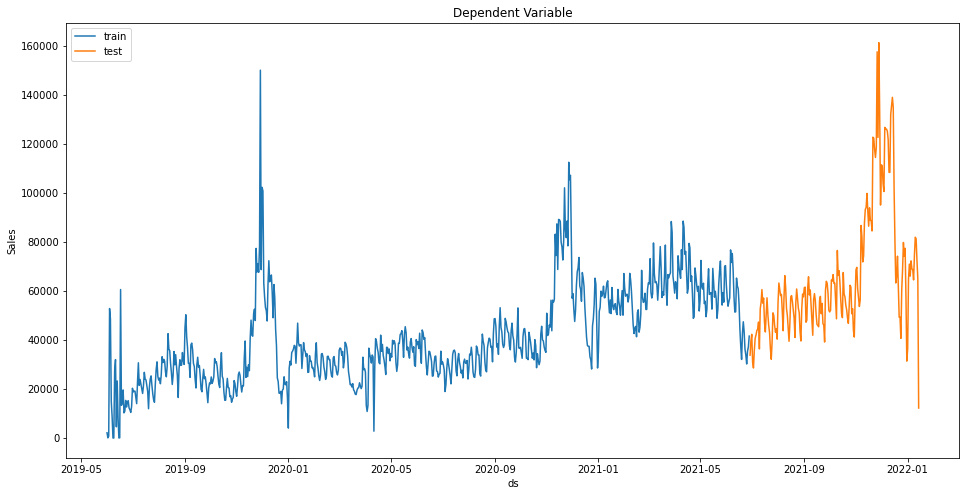

In [14]:
# Lets plot the both data
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x='ds', y='y', label='train', data=train, ax=ax)
sns.lineplot(x='ds', y='y', label='test', data=test, ax=ax)
plt.ticklabel_format(style='plain', axis='y')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='Sales');
plt.ticklabel_format(style='plain', axis='y')

## 6- Modeling

In [32]:
m = Prophet(weekly_seasonality=True, daily_seasonality=True, n_changepoints=3)
m.add_seasonality(name='daily', period= 300, fourier_order=2)
#m.add_country_holidays(country_name='UK')
m.fit(train)

/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [31]:
future = m.make_future_dataframe(periods= test.shape[0]+30, freq = 'D')
forecast = m.predict(future)
forecast

/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-06-01,7339.930683,10828.012421,31960.287071,7339.930683,7339.930683,14631.354483,14631.354483,14631.354483,20777.19808,...,-5818.425983,-5818.425983,-5818.425983,-327.417614,-327.417614,-327.417614,0.0,0.0,0.0,21971.285166
1,2019-06-02,7365.988093,19815.331593,42209.612060,7365.988093,7365.988093,23398.723193,23398.723193,23398.723193,20777.19808,...,3468.978931,3468.978931,3468.978931,-847.453818,-847.453818,-847.453818,0.0,0.0,0.0,30764.711286
2,2019-06-03,7392.045503,20565.736588,43251.186949,7392.045503,7392.045503,24397.042279,24397.042279,24397.042279,20777.19808,...,5056.137133,5056.137133,5056.137133,-1436.292934,-1436.292934,-1436.292934,0.0,0.0,0.0,31789.087782
3,2019-06-04,7418.102913,17958.055177,39370.654759,7418.102913,7418.102913,20876.303465,20876.303465,20876.303465,20777.19808,...,2186.934262,2186.934262,2186.934262,-2087.828877,-2087.828877,-2087.828877,0.0,0.0,0.0,28294.406378
4,2019-06-05,7444.160323,15485.548590,36582.424660,7444.160323,7444.160323,18568.743769,18568.743769,18568.743769,20777.19808,...,586.258007,586.258007,586.258007,-2794.712318,-2794.712318,-2794.712318,0.0,0.0,0.0,26012.904092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,2022-02-09,61772.212355,69088.907499,92307.433000,59379.436210,64333.609659,18555.838833,18555.838833,18555.838833,20777.19808,...,586.258007,586.258007,586.258007,-2807.617254,-2807.617254,-2807.617254,0.0,0.0,0.0,80328.051188
985,2022-02-10,61847.124715,66644.812088,88815.017197,59442.954506,64433.239430,15799.475815,15799.475815,15799.475815,20777.19808,...,-2198.399620,-2198.399620,-2198.399620,-2779.322645,-2779.322645,-2779.322645,0.0,0.0,0.0,77646.600530
986,2022-02-11,61922.037076,65400.973187,87983.020864,59507.245243,64529.161671,14799.504306,14799.504306,14799.504306,20777.19808,...,-3281.482729,-3281.482729,-3281.482729,-2696.211045,-2696.211045,-2696.211045,0.0,0.0,0.0,76721.541381
987,2022-02-12,61996.949436,63252.360233,85610.349069,59574.710839,64625.292068,12396.443683,12396.443683,12396.443683,20777.19808,...,-5818.425983,-5818.425983,-5818.425983,-2562.328414,-2562.328414,-2562.328414,0.0,0.0,0.0,74393.393119


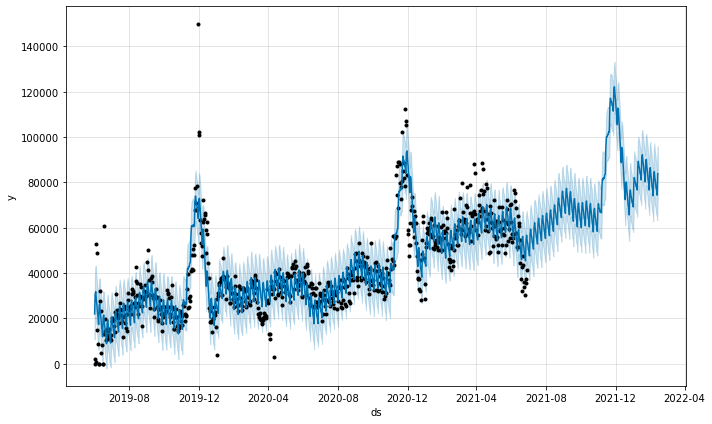

In [33]:
# Plot the forecast
fig1 = m.plot(forecast)

/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



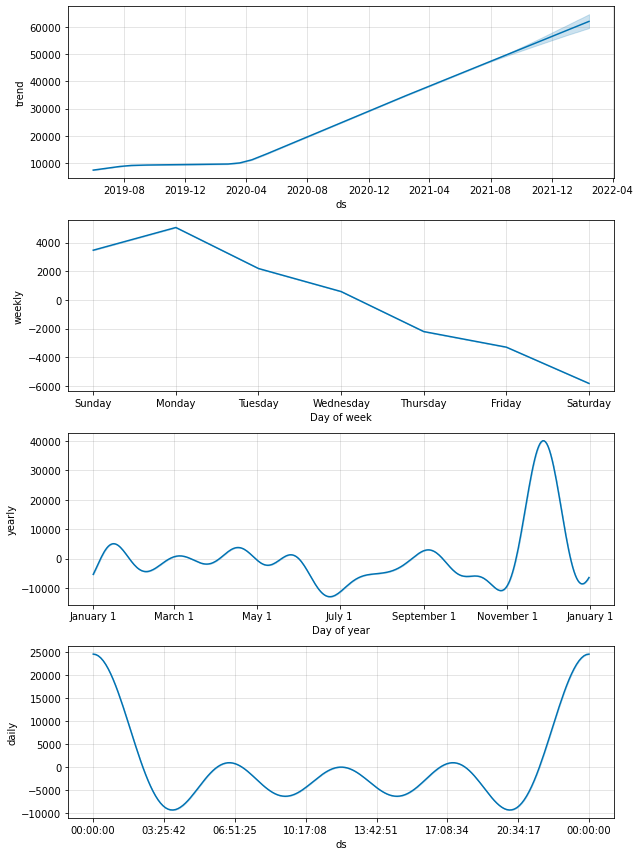

In [34]:
# Plot the forecast components
fig2 = m.plot_components(forecast)

Campare the the prediction and actual values

<function matplotlib.pyplot.show(close=None, block=None)>

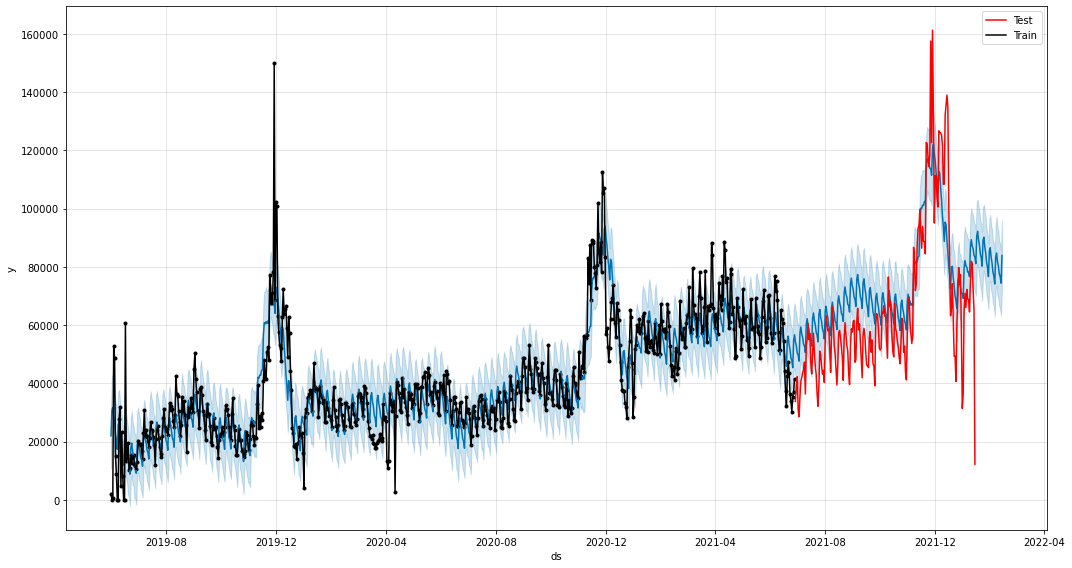

In [35]:
 #Let's coampare the prediction with actual

f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)


fig=m.plot(forecast, ax=ax)
ax.plot(test.ds, test.y, color='r', label='Test')
ax.plot(train.ds, train.y, color='black', label='Train')
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.show

In [102]:
forecast.shape

(830, 22)

## 7 - Model Evaluation

In [36]:
# Merge test and forcast dataframe
df_merge = pd.merge(test, forecast[['ds','yhat_lower','yhat_upper','yhat']],on='ds')
df_merge = df_merge[['ds','yhat_lower','yhat_upper','yhat','y']]
df_merge.head()

,ds,yhat_lower,yhat_upper,yhat,y
0,2021-06-29,42857.604070,65226.983628,54115.523946,33795.051061
1,2021-06-30,42600.677171,63931.974914,52849.904886,39599.483330
2,2021-07-01,39914.600261,61054.759562,50433.387216,42308.067441
3,2021-07-02,38534.466289,60286.350092,49744.755470,30953.446392
4,2021-07-03,36872.887152,58775.313021,47621.920432,28577.994334


In [37]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

y_true = df_merge['y'].values
y_pred = df_merge['yhat'].values
mae_01 = mean_absolute_error(y_true, y_pred)
mape_01 = mean_absolute_percentage_error(y_true, y_pred)

print('MAPE:',mape_01, 'MAE:', mae_01 )

MAPE: 0.25675417319685623 MAE: 13212.703122462277


## 8- Crossvalidation

In [38]:
from fbprophet.diagnostics import cross_validation
df_cv=cross_validation(model=m, horizon='100days', period='100days')
mape=mean_absolute_percentage_error(df_cv.y, df_cv.yhat)
print('MAPE: ', mape)

INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-09-01 00:00:00 and 2021-03-20 00:00:00
  0%|          | 0/3 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 33%|███▎      | 1/3 [00:12<00:24, 12.05s/it]/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

MAPE:  0.23792308105995782


In [39]:
from fbprophet.diagnostics import performance_metrics
per_df = performance_metrics(df_cv)
per_df.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,10 days,1.291029e+08,11362.344494,7887.986805,0.127962,0.101459,0.700000
1,11 days,1.230719e+08,11093.777914,7928.037405,0.136458,0.111266,0.700000
2,12 days,1.342912e+08,11588.406488,8909.971522,0.158864,0.136549,0.666667
3,13 days,1.443627e+08,12015.102614,9617.714397,0.175414,0.180988,0.633333
4,14 days,1.520567e+08,12331.129279,10143.679470,0.191740,0.203304,0.600000


Compare forecasted and actual values after crossvalidation

Text(0.5, 1.0, 'Forecast Vs Actual')

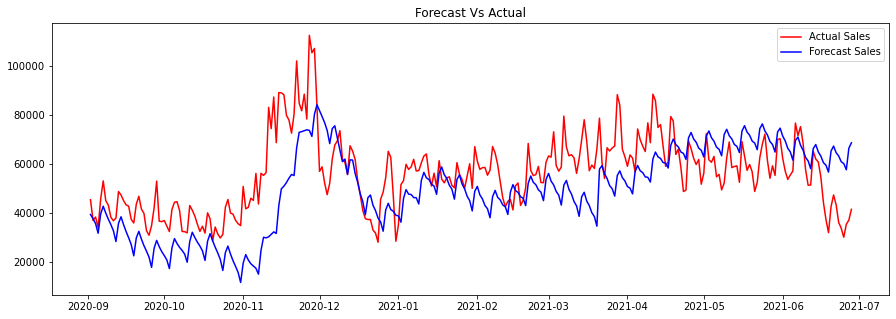

In [40]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(df_cv['ds'], df_cv['y'], color='r', label='Actual Sales')
ax.plot(df_cv['ds'], df_cv['yhat'], color='b', label='Forecast Sales')
plt.legend()

plt.title('Forecast Vs Actual')

## 9- Parameter tuning

In [41]:
import itertools

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],   
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the MAE for each params here
mapes = [] # Store the MAPE for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])
    mapes.append(df_p['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
tuning_results['mape'] = mapes

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Making 25 forecasts with cutoffs between 2020-06-03 00:00:00 and 2021-05-29 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ffb4bada970>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Making 25 forecasts with cutoffs between 2020-06-03 00:00:00 and 2021-05-29 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.proces

In [43]:
tuning_results.sort_values(['mae','mape'])

,changepoint_prior_scale,seasonality_prior_scale,mae,mape
4,0.010,0.01,9914.496595,0.199054
8,0.100,0.01,10065.871107,0.201983
12,0.500,0.01,10072.279185,0.202034
5,0.010,0.10,10349.692108,0.209179
7,0.010,10.00,10459.344658,0.211827
6,0.010,1.00,10464.111788,0.212509
13,0.500,0.10,10535.778382,0.203371
15,0.500,10.00,10747.355057,0.207656
14,0.500,1.00,10770.999279,0.208138
10,0.100,1.00,10839.699199,0.222305


## 12-  Finding the best  parameters and train the model with tunned parameters and check the result

In [44]:
best_params = all_params[np.argmin(mapes)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


In [45]:
m_01 = Prophet(weekly_seasonality=True,yearly_seasonality=True,
changepoint_prior_scale = best_params['changepoint_prior_scale'],
seasonality_prior_scale = best_params['seasonality_prior_scale'] )
m_01.add_seasonality(name='monthly', period=24, fourier_order=1)
#m.add_country_holidays(country_name='UK')
model = m_01.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [47]:
future_01 = model.make_future_dataframe(periods=7, freq = 'D')
forecast_01 = model.predict(future_01)

/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



## Check the model improvement after tunning the parameters

In [53]:
df_merge_1 = pd.merge(test, forecast_01[['ds','yhat_lower','yhat_upper','yhat']],on='ds')
df_merge_1 = df_merge_1[['ds','yhat_lower','yhat_upper','yhat','y']]
df_merge_1.head()

,ds,yhat_lower,yhat_upper,yhat,y
0,2021-06-29,46476.889835,67707.396596,56774.664317,33795.051061
1,2021-06-30,44232.127673,66891.473891,55435.316993,39599.483330
2,2021-07-01,41038.342741,64069.144275,52997.037121,42308.067441
3,2021-07-02,40068.795521,63804.421158,52114.978740,30953.446392
4,2021-07-03,37874.299935,61342.072997,49943.896296,28577.994334


In [54]:
y_true_01 = df_merge_1['y'].values
y_pred_01= df_merge_1['yhat'].values
#mae_02 = mean_absolute_error(y_true_01, y_pred_01)
mape_02 = mean_absolute_percentage_error(y_true_01, y_pred_01)

Compare the mape before and after tuning the parameters

In [55]:
print('mape before tuning parameters:',mape_01)
print('mape after tuning prarameters:',mape_02)


mape before tuning parameters: 0.25675417319685623
mape after tuning prarameters: 0.5555565787915117


In [ ]:
y_true = df_merge['y'].values
y_pred = df_merge['yhat'].values
#mae_01 = mean_absolute_error(y_true, y_pred)
mape_01 = mean_absolute_percentage_error(y_true, y_pred)

print('mape before tuning parameters:',mape_01)